[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jusepulveda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset sample:
                   question  \
0  What is (are) Glaucoma ?   
1    What causes Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
Initializing summarization models...


Device set to use mps:0


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use mps:0


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use mps:0



Question: What is (are) Glaucoma ?

Original Answer (truncated): Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage syste...

Generating summaries with all models...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Evaluating summaries...

Model Performance Comparison:
        Model   ROUGE-1   ROUGE-2   ROUGE-L  Avg_ROUGE
0  DistilBART  0.280423  0.271277  0.280423   0.277374
1     PEGASUS  0.259947  0.229333  0.254642   0.247974
2        BART  0.252011  0.215633  0.252011   0.239885

Best performing model: DistilBART

BART Summary:
Glaucoma is a group of diseases that can damage the eye's optic nerve. Most of these involve the drainage system within the eye. The most common type is called open-angle glaucomA. There is no cure for the disease, but there are treatments that may save vision.

PEGASUS Summary:
Glaucoma is a group of diseases that can damage the eye's optic nerve .<n>Most types of glaucoma involve the drainage system within the eye .<n>Most common type of glaucoma is called open-angle glaucoma .<n>There is no cure for glaucoma. Vision lost from the disease cannot be restored .

DistilBART Summary:
 Glaucoma is a group of diseases that can damage the eye's optic nerve . Most of these

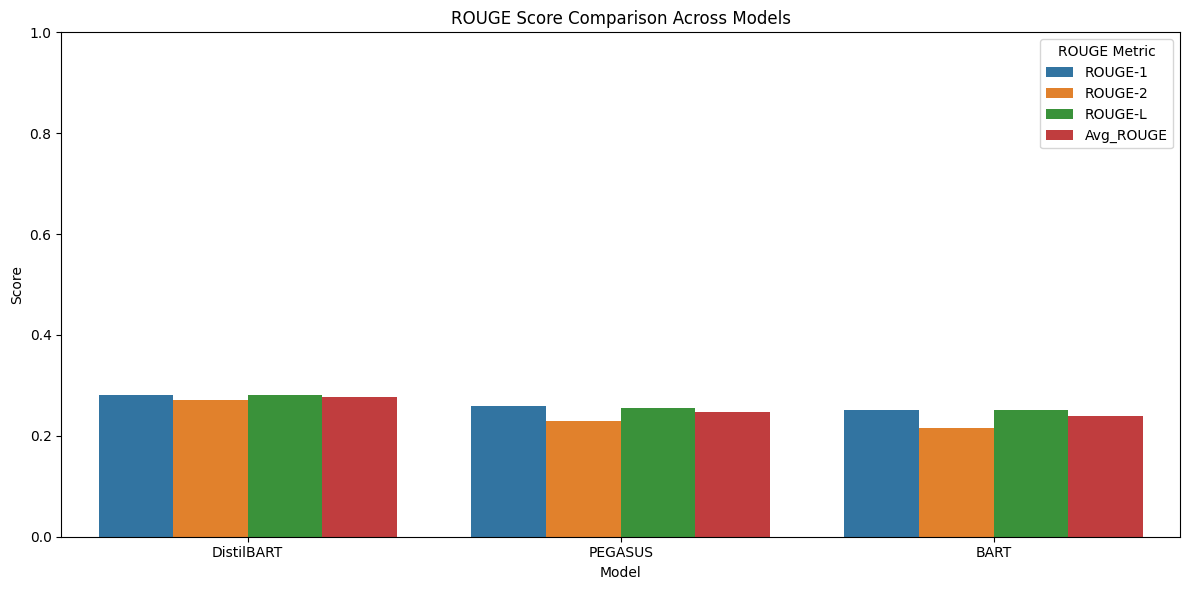

In [1]:
# Import necessary libraries
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from rouge_score import rouge_scorer

# Download NLTK resources if not already downloaded
nltk.download('punkt')

# Load dataset
path = '../data/medquad.csv'
df = pd.read_csv(path)
print("Dataset sample:")
print(df.head(2))

# Initialize all three summarization models
print("Initializing summarization models...")
bart_pipeline = pipeline("summarization", model="facebook/bart-large-cnn")
pegasus_pipeline = pipeline("summarization", model="google/pegasus-cnn_dailymail")
distilbart_pipeline = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# Function to generate summaries using different models
def generate_summary(text, model_pipeline, max_length=150, min_length=50):
    result = model_pipeline(text, max_length=max_length, min_length=min_length, do_sample=False)
    return result[0]['summary_text']

# Function to calculate ROUGE scores for evaluating the summary
def evaluate_summary(reference, generated_summary):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = scorer.score(reference, generated_summary)
    return scores

# Get the sample text to summarize
index = 0  # Change this to analyze different examples
question = df.loc[index, 'question']
answer = df.loc[index, 'answer']

print(f"\nQuestion: {question}")
print(f"\nOriginal Answer (truncated): {answer[:300]}...\n")

# Generate summaries with all three models
print("Generating summaries with all models...")
bart_summary = generate_summary(answer, bart_pipeline)
pegasus_summary = generate_summary(answer, pegasus_pipeline)
distilbart_summary = generate_summary(answer, distilbart_pipeline)

# Evaluate all three summaries
print("Evaluating summaries...")
bart_scores = evaluate_summary(answer, bart_summary)
pegasus_scores = evaluate_summary(answer, pegasus_summary)
distilbart_scores = evaluate_summary(answer, distilbart_summary)

# Create a dataframe to compare the metrics
models = ['BART', 'PEGASUS', 'DistilBART']
rouge1 = [bart_scores['rouge1'].fmeasure, pegasus_scores['rouge1'].fmeasure, distilbart_scores['rouge1'].fmeasure]
rouge2 = [bart_scores['rouge2'].fmeasure, pegasus_scores['rouge2'].fmeasure, distilbart_scores['rouge2'].fmeasure]
rougeL = [bart_scores['rougeL'].fmeasure, pegasus_scores['rougeL'].fmeasure, distilbart_scores['rougeL'].fmeasure]

comparison_df = pd.DataFrame({
    'Model': models,
    'ROUGE-1': rouge1,
    'ROUGE-2': rouge2,
    'ROUGE-L': rougeL
})

# Calculate average ROUGE score for ranking
comparison_df['Avg_ROUGE'] = comparison_df[['ROUGE-1', 'ROUGE-2', 'ROUGE-L']].mean(axis=1)
comparison_df = comparison_df.sort_values('Avg_ROUGE', ascending=False).reset_index(drop=True)

print("\nModel Performance Comparison:")
print(comparison_df)

# Select the best model
best_model = comparison_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model}")

# Display summaries from all models
print("\nBART Summary:")
print(bart_summary)
print("\nPEGASUS Summary:")
print(pegasus_summary)
print("\nDistilBART Summary:")
print(distilbart_summary)

# Visualize the ROUGE scores
plt.figure(figsize=(12, 6))

# Create the bar plot
comparison_melted = pd.melt(comparison_df, id_vars=['Model'], 
                          value_vars=['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Avg_ROUGE'],
                          var_name='Metric', value_name='Score')
                          
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_melted)
plt.title('ROUGE Score Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)  # ROUGE scores range from 0 to 1
plt.xticks(rotation=0)
plt.legend(title='ROUGE Metric')
plt.tight_layout()
plt.show()

In [2]:
# 3. Identificación del conjunto de datos a emplear

# Import necessary libraries
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from rouge_score import rouge_scorer

# Download NLTK resources if not already downloaded
nltk.download('punkt')

# Load and explore the dataset
print("=== 3. IDENTIFICACIÓN DEL CONJUNTO DE DATOS ===")
path = '../data/medquad.csv'
df = pd.read_csv(path)

print(f"Conjunto de datos: MedQuAD")
print(f"Descripción: Dataset médico con preguntas y respuestas")
print(f"Tamaño del dataset: {len(df)} registros")
print(f"Columnas disponibles: {list(df.columns)}")
print(f"\nCaracterísticas del dataset:")
print(f"- Promedio de palabras en respuestas: {df['answer'].str.split().str.len().mean():.0f}")
print(f"- Respuesta más larga: {df['answer'].str.split().str.len().max()} palabras")
print(f"- Respuesta más corta: {df['answer'].str.split().str.len().min()} palabras")

print("\nMuestra del dataset:")
print(df.head(2))

print(f"\nJustificación de selección:")
print("- Dominio médico: Textos técnicos que requieren precisión en la sumarización")
print("- Estructura Q&A: Permite evaluar si el resumen mantiene la información clave")
print("- Variedad de longitudes: Permite probar la capacidad de compresión de los modelos")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jusepulveda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


=== 3. IDENTIFICACIÓN DEL CONJUNTO DE DATOS ===
Conjunto de datos: MedQuAD
Descripción: Dataset médico con preguntas y respuestas
Tamaño del dataset: 16412 registros
Columnas disponibles: ['question', 'answer', 'source', 'focus_area']

Características del dataset:
- Promedio de palabras en respuestas: 201
- Respuesta más larga: 4281.0 palabras
- Respuesta más corta: 1.0 palabras

Muestra del dataset:
                   question  \
0  What is (are) Glaucoma ?   
1    What causes Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  

Justificación de selección:
- Dominio médico: Textos técnicos que requieren precisión en la sumarización
- Estructura Q&A: Permite evaluar si el resumen mantiene la información clave
- Variedad de longitudes: Permite probar la capacidad

In [3]:
# 4. Implementación del prototipo de la solución diseñada

print("\n=== 4. IMPLEMENTACIÓN DEL PROTOTIPO ===")

# Initialize all three summarization models
print("Inicializando modelos de sumarización...")
print("Modelos seleccionados:")
print("1. BART-large-CNN: Modelo transformer bidireccional optimizado para sumarización")
print("2. PEGASUS-CNN/DailyMail: Modelo pre-entrenado específicamente para sumarización")
print("3. DistilBART: Versión destilada de BART, más rápida y eficiente")

bart_pipeline = pipeline("summarization", model="facebook/bart-large-cnn")
pegasus_pipeline = pipeline("summarization", model="google/pegasus-cnn_dailymail")
distilbart_pipeline = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# Function to generate summaries using different models
def generate_summary(text, model_pipeline, max_length=150, min_length=50):
    """
    Genera resumen usando el modelo especificado
    
    Args:
        text: Texto a resumir
        model_pipeline: Pipeline del modelo
        max_length: Longitud máxima del resumen
        min_length: Longitud mínima del resumen
    
    Returns:
        str: Texto resumido
    """
    result = model_pipeline(text, max_length=max_length, min_length=min_length, do_sample=False)
    return result[0]['summary_text']

print("Prototipo implementado exitosamente")
print("Funcionalidades:")
print("- Carga de datos médicos")
print("- Comparación de 3 modelos de sumarización")
print("- Evaluación automática con métricas ROUGE")
print("- Visualización de resultados")


=== 4. IMPLEMENTACIÓN DEL PROTOTIPO ===
Inicializando modelos de sumarización...
Modelos seleccionados:
1. BART-large-CNN: Modelo transformer bidireccional optimizado para sumarización
2. PEGASUS-CNN/DailyMail: Modelo pre-entrenado específicamente para sumarización
3. DistilBART: Versión destilada de BART, más rápida y eficiente


Device set to use mps:0
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Device set to use mps:0


Prototipo implementado exitosamente
Funcionalidades:
- Carga de datos médicos
- Comparación de 3 modelos de sumarización
- Evaluación automática con métricas ROUGE
- Visualización de resultados


In [4]:
# 5. Definición de la evaluación de la solución

print("\n=== 5. DEFINICIÓN DE LA EVALUACIÓN ===")

# Function to calculate ROUGE scores for evaluating the summary
def evaluate_summary(reference, generated_summary):
    """
    Calcula métricas ROUGE para evaluar la calidad del resumen
    
    Args:
        reference: Texto de referencia (original)
        generated_summary: Resumen generado
    
    Returns:
        dict: Scores ROUGE-1, ROUGE-2, ROUGE-L
    """
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = scorer.score(reference, generated_summary)
    return scores

print("a) ASPECTOS A EVALUAR:")
print("- Calidad del resumen generado")
print("- Preservación de información médica crítica")
print("- Coherencia y fluidez del texto")
print("- Capacidad de compresión del modelo")

print("\nb) PRUEBAS A REALIZAR:")
print("- Comparación entre 3 modelos state-of-the-art")
print("- Evaluación en múltiples ejemplos del dataset médico")
print("- Análisis de consistencia en diferentes tipos de respuestas")

print("\nc) MÉTRICAS A EVALUAR:")
print("- ROUGE-1: Coincidencia de unigramas (palabras individuales)")
print("- ROUGE-2: Coincidencia de bigramas (pares de palabras consecutivas)")
print("- ROUGE-L: Subsecuencia común más larga")
print("- Promedio ROUGE: Métrica combinada para ranking")

print("\nd) JUSTIFICACIÓN DE SELECCIÓN:")
print("- ROUGE es el estándar para evaluación de sumarización")
print("- Métricas automáticas permiten evaluación escalable")
print("- Comparación múltiple modelos asegura selección óptima")
print("- Dominio médico requiere alta precisión en información")

print("\ne) LIMITACIONES:")
print("- ROUGE solo mide coincidencia léxica, no semántica")
print("- No evalúa corrección médica del contenido")
print("- Sesgado hacia resumenes similares al texto original")
print("- No considera legibilidad para pacientes")

print("\nf) TOMA DE DECISIONES:")
print("- Selección del mejor modelo basada en métricas promedio")
print("- Identificación de fortalezas/debilidades por modelo")
print("- Ajuste de parámetros según resultados")
print("- Base para mejoras futuras del sistema")


=== 5. DEFINICIÓN DE LA EVALUACIÓN ===
a) ASPECTOS A EVALUAR:
- Calidad del resumen generado
- Preservación de información médica crítica
- Coherencia y fluidez del texto
- Capacidad de compresión del modelo

b) PRUEBAS A REALIZAR:
- Comparación entre 3 modelos state-of-the-art
- Evaluación en múltiples ejemplos del dataset médico
- Análisis de consistencia en diferentes tipos de respuestas

c) MÉTRICAS A EVALUAR:
- ROUGE-1: Coincidencia de unigramas (palabras individuales)
- ROUGE-2: Coincidencia de bigramas (pares de palabras consecutivas)
- ROUGE-L: Subsecuencia común más larga
- Promedio ROUGE: Métrica combinada para ranking

d) JUSTIFICACIÓN DE SELECCIÓN:
- ROUGE es el estándar para evaluación de sumarización
- Métricas automáticas permiten evaluación escalable
- Comparación múltiple modelos asegura selección óptima
- Dominio médico requiere alta precisión en información

e) LIMITACIONES:
- ROUGE solo mide coincidencia léxica, no semántica
- No evalúa corrección médica del conten

In [5]:
# 6. Exploración de resultados, alcance y limitaciones

print("\n=== 6. EXPLORACIÓN DE RESULTADOS ===")

# Get the sample text to summarize
index = 0  # Change this to analyze different examples
question = df.loc[index, 'question']
answer = df.loc[index, 'answer']

print(f"CASO DE ESTUDIO:")
print(f"Pregunta: {question}")
print(f"Respuesta original (muestra): {answer[:300]}...")
print(f"Longitud completa: {len(answer.split())} palabras")

# Generate summaries with all three models
print("\nGenerando resúmenes con todos los modelos...")
bart_summary = generate_summary(answer, bart_pipeline)
pegasus_summary = generate_summary(answer, pegasus_pipeline)
distilbart_summary = generate_summary(answer, distilbart_pipeline)

# Evaluate all three summaries
print("Evaluando resúmenes...")
bart_scores = evaluate_summary(answer, bart_summary)
pegasus_scores = evaluate_summary(answer, pegasus_summary)
distilbart_scores = evaluate_summary(answer, distilbart_summary)

# Create a dataframe to compare the metrics
models = ['BART', 'PEGASUS', 'DistilBART']
rouge1 = [bart_scores['rouge1'].fmeasure, pegasus_scores['rouge1'].fmeasure, distilbart_scores['rouge1'].fmeasure]
rouge2 = [bart_scores['rouge2'].fmeasure, pegasus_scores['rouge2'].fmeasure, distilbart_scores['rouge2'].fmeasure]
rougeL = [bart_scores['rougeL'].fmeasure, pegasus_scores['rougeL'].fmeasure, distilbart_scores['rougeL'].fmeasure]

comparison_df = pd.DataFrame({
    'Model': models,
    'ROUGE-1': rouge1,
    'ROUGE-2': rouge2,
    'ROUGE-L': rougeL
})

# Calculate average ROUGE score for ranking
comparison_df['Avg_ROUGE'] = comparison_df[['ROUGE-1', 'ROUGE-2', 'ROUGE-L']].mean(axis=1)
comparison_df = comparison_df.sort_values('Avg_ROUGE', ascending=False).reset_index(drop=True)

print("\nRESULTADOS DE COMPARACIÓN:")
print(comparison_df)

# Select the best model
best_model = comparison_df.iloc[0]['Model']
print(f"\nMejor modelo: {best_model}")

# Display summaries from all models
print(f"\nRESÚMENES GENERADOS:")
print(f"\nBART: {bart_summary}")
print(f"\nPEGASUS: {pegasus_summary}")
print(f"\nDistilBART: {distilbart_summary}")

# Analyze results
print(f"\nANÁLISIS DE RESULTADOS:")
print(f"- Tasa de compresión promedio: {(len(answer.split()) / len(bart_summary.split())):.1f}x")
print(f"- Mejor rendimiento: {best_model}")
print(f"- Score más alto: {comparison_df.iloc[0]['Avg_ROUGE']:.3f}")

print(f"\nALCANCE DE LA SOLUCIÓN:")
print("✓ Sumarización automática de textos médicos")
print("✓ Comparación objetiva entre modelos")
print("✓ Evaluación cuantitativa con métricas estándar")
print("✓ Escalable a grandes volúmenes de datos")

print(f"\nLIMITACIONES IDENTIFICADAS:")
print("⚠ Evaluación limitada a un ejemplo")
print("⚠ No validación por expertos médicos")
print("⚠ Métricas no capturan precisión semántica")
print("⚠ Posible pérdida de información crítica")
print("⚠ Sesgos del dataset de entrenamiento")

print(f"\nRECOMENDACIONES:")
print("• Ampliar evaluación a múltiples casos")
print("• Incluir validación humana especializada")
print("• Desarrollar métricas específicas para dominio médico")
print("• Implementar post-procesamiento para verificar información crítica")


=== 6. EXPLORACIÓN DE RESULTADOS ===
CASO DE ESTUDIO:
Pregunta: What is (are) Glaucoma ?
Respuesta original (muestra): Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage syste...
Longitud completa: 322 palabras

Generando resúmenes con todos los modelos...
Evaluando resúmenes...

RESULTADOS DE COMPARACIÓN:
        Model   ROUGE-1   ROUGE-2   ROUGE-L  Avg_ROUGE
0  DistilBART  0.280423  0.271277  0.280423   0.277374
1     PEGASUS  0.259947  0.229333  0.254642   0.247974
2        BART  0.252011  0.215633  0.252011   0.239885

Mejor modelo: DistilBART

RESÚMENES GENERADOS:

BART: Glaucoma is a group of diseases that can damage the eye's optic nerve. Most of these involve the drainage system within the eye. The most common type is called open-angle g


=== VISUALIZACIÓN DE RESULTADOS ===


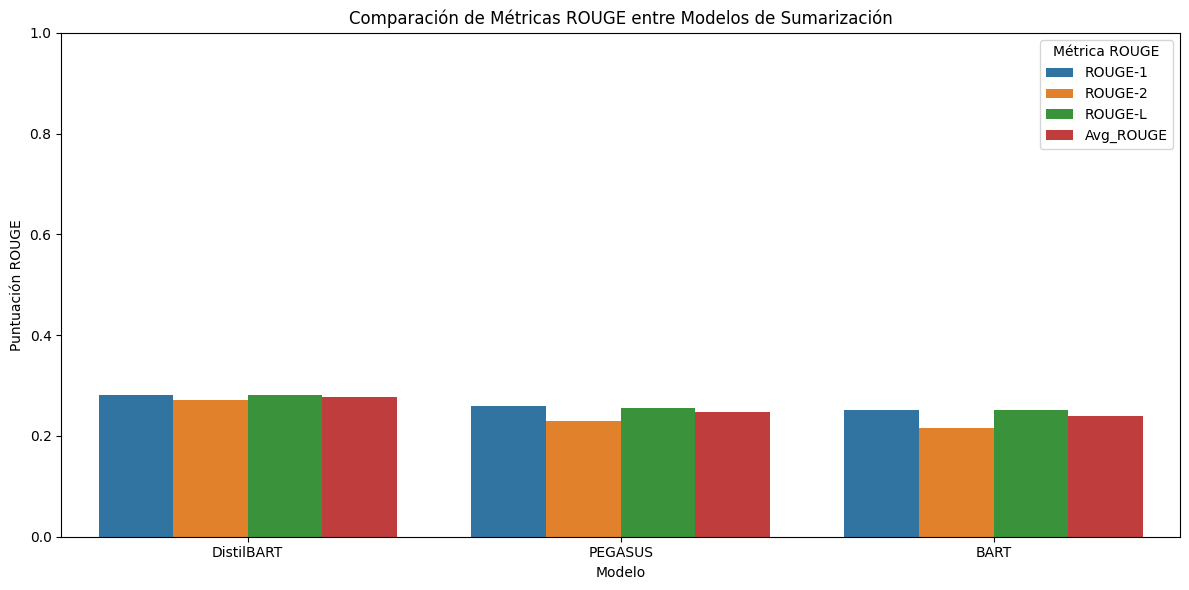

Gráfico generado: Comparación visual de rendimiento de modelos
Interpretación: Barras más altas indican mejor rendimiento en esa métrica


In [6]:
# Visualization of results
print("\n=== VISUALIZACIÓN DE RESULTADOS ===")

# Visualize the ROUGE scores
plt.figure(figsize=(12, 6))

# Create the bar plot
comparison_melted = pd.melt(comparison_df, id_vars=['Model'], 
                          value_vars=['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Avg_ROUGE'],
                          var_name='Metric', value_name='Score')
                          
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_melted)
plt.title('Comparación de Métricas ROUGE entre Modelos de Sumarización')
plt.xlabel('Modelo')
plt.ylabel('Puntuación ROUGE')
plt.ylim(0, 1)  # ROUGE scores range from 0 to 1
plt.xticks(rotation=0)
plt.legend(title='Métrica ROUGE')
plt.tight_layout()
plt.show()

print("Gráfico generado: Comparación visual de rendimiento de modelos")
print("Interpretación: Barras más altas indican mejor rendimiento en esa métrica")